<a href="https://colab.research.google.com/github/arutraj/ML_Basics/blob/main/7_2_PyTorch_best_practices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Best practices for creating DL models in Pytorch

<ol>1. Test if the model works as expected before training or evaluation</ol>
<ol>2. Write functions to minimize code repetitions</ol>
<ol>3. Save best model and use it for prediction</ol>

In [1]:
#mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#extract the images
#!unzip '/content/drive/My Drive/Dataset.zip'
!ls /content/drive/MyDrive/AnalyticsVidya/DeepLearning/images | wc -l

2352


In [3]:
# importing the required libraries
%matplotlib inline
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# importing libraries for defining the architecture of model
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import Linear, ReLU, BCELoss, Sequential, Sigmoid, Conv2d, MaxPool2d

In [4]:
#reading a csv file
data = pd.read_csv('/content/drive/MyDrive/AnalyticsVidya/DeepLearning/emergency_classification.csv')

In [5]:
# creating a random seed
seed = 42

In [6]:
#first 5 rows
data.head()

,image_names,emergency_or_not
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1


In [8]:
# load images and store it in numpy array

# empty list to store the images
X = []

# iterating over each image
for img_name in data.image_names:

    # loading the image using its name
    img = plt.imread('/content/drive/MyDrive/AnalyticsVidya/DeepLearning/images/' + img_name)

    # normalizing the pixel values
    img = img / 255

    # saving each image in the list
    X.append(img)

# converting the list of images into array
X=np.array(X)

# storing the target variable in separate variable
y = data.emergency_or_not.values

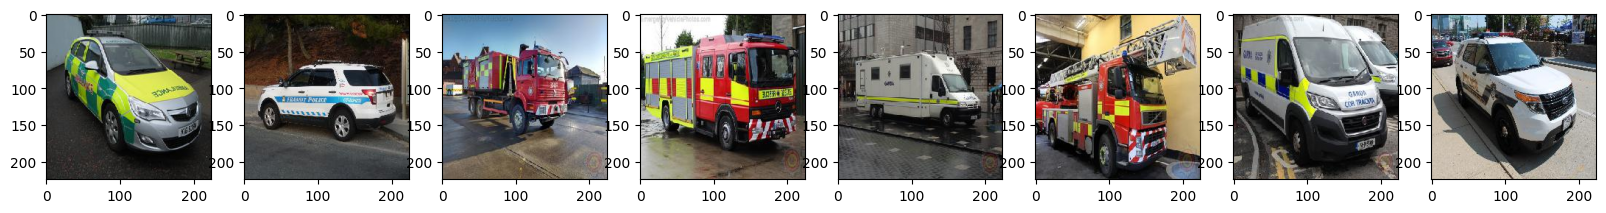

In [10]:
#Glance at the images
fig, axes = plt.subplots(ncols=8,figsize=(20,10))
for i in range(8):
  axes[i].imshow(X[i])

In [11]:
#reshaping array as pytorch acceps channels as the first dimension of an image
X = np.moveaxis(X, -1, 1)
print(X.shape)

(2352, 3, 224, 224)


In [12]:
#create a training and validation set
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

In [13]:
# shape of training and validation set
(X_train.shape, y_train.shape), (X_valid.shape, y_valid.shape)

(((1646, 3, 224, 224), (1646,)), ((706, 3, 224, 224), (706,)))

In [14]:
# converting training and validation set to PyTorch tensor
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

X_valid = torch.FloatTensor(X_valid)
y_valid = torch.FloatTensor(y_valid)

## 1. Test if the model works as expected before training or evaluation

In [38]:
# Define CNN architecture

# Input
# Conv2d(64, kernel_size=(3, 3), stride=(1, 1), 'relu')
# MaxPool2d((2, 2), stride=2)
# Conv2d(128, kernel_size=(3, 3), stride=(1, 1), 'relu')
# MaxPool2d((2, 2), stride=2)
# Linear(64, 'relu')
# Linear(1, 'sigmoid')

class Net(nn.Module):
  def __init__(self):
      super(Net, self).__init__()

      #define the convolution block
      self.conv_layers = Sequential(

         #[bs,3,224,224]
         Conv2d(in_channels=3, out_channels=64, kernel_size=3),

         #[bs,64,222,222]
         ReLU(),

         #[bs,64,222,222]
         MaxPool2d(kernel_size=2, stride=2),

         #[bs,64,111,111]
         Conv2d(64, 128, 3),

         #[bs,128,109,109]
         ReLU(),

         #[bs,128,109,109]
         MaxPool2d(2, 2)

         )

      #define the dense block
      self.linear_layers=Sequential(

           #[bs,128,54,54]
           Linear(128 * 54 * 54, 64),

           #[bs,128*54*54]
           ReLU(),

           #[bs,64]
           Linear(64, 1),

           #[bs,1]
           Sigmoid()
       )

  #Defining the forward pass
  def forward(self, x):

    #convolution block
    x = self.conv_layers(x)

    #flattening the output
    #x = x.view(x.size(0),-1)
    x = x.reshape(x.size(0), -1)

    #dense block
    x = self.linear_layers(x)

    return x

In [39]:
# for same default initialization
torch.manual_seed(32)

#define the model
model = Net()

In [40]:
#layers used in the model
model

Net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=373248, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [41]:
#pass an image to understand whether the defined architecture is valid or not
model(X_train[20].view(1,3,224,224))

tensor([[0.4953]], grad_fn=<SigmoidBackward0>)

In [50]:
#define optimizer and loss
optimizer = Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [51]:
#shape of the image
print(X.shape)

(2352, 3, 224, 224)


## 2. Write functions to minimize code repetitions

In [52]:
#define metric
def binary_accuracy(preds, y):

    #round predictions to the closest integer
    rounded_preds = torch.round(preds)

    #no. of correctly classified
    correct = (rounded_preds == y).float()

    #compute accuracy
    acc = correct.sum() / len(correct)
    return acc

In [36]:
# define training function
def train(X,y,batch_size):

  #activate training phase
  model.train()

  #initialization
  epoch_loss, epoch_acc= 0, 0
  no_of_batches = 0

  #randomly create indices
  indices= torch.randperm(len(X))

  #loading in batches
  for i in range(0,len(indices),batch_size):

    #indices for a batch
    ind = indices[i:i+batch_size]

    #batch
    batch_x=X[ind]
    batch_y=y[ind]

    #push to cuda
    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    #clear gradients
    optimizer.zero_grad()

    #forward pass
    outputs = model(batch_x).squeeze()

    #converting to a 1 dimensional tensor
    #outputs = outputs.squeeze()

    #calculate loss and accuracy
    loss = criterion(outputs, batch_y)
    acc = binary_accuracy(outputs, batch_y)

    #Backward pass
    loss.backward()

    #Update weights
    optimizer.step()

    #Keep track of the loss and accuracy of a epoch
    epoch_loss = epoch_loss + loss.item()
    epoch_acc  = epoch_acc  + acc.item()

    #No. of batches
    no_of_batches = no_of_batches+1

  return epoch_loss/no_of_batches, epoch_acc/no_of_batches

In [33]:
# define evaluation function
def evaluate(X,y,batch_size):

  #deactivate training phase
  model.eval()

  #initialization
  epoch_loss, epoch_acc= 0, 0
  no_of_batches = 0

  #randomly create indices
  indices= torch.randperm(len(X))

  #deactivates autograd
  with torch.no_grad():

    #loading in batches
    for i in range(0,len(indices),batch_size):

      #indices for a batch
      ind = indices[i:i+batch_size]

      #batch
      batch_x= X[ind]
      batch_y= y[ind]

      #push to cuda
      if torch.cuda.is_available():
          batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

      #Forward pass
      outputs = model(batch_x)

      #converting the output to 1 Dimensional tensor
      outputs = outputs.squeeze()

      # Calculate loss and accuracy
      loss = criterion(outputs, batch_y)
      acc = binary_accuracy(outputs, batch_y)

      #keep track of loss and accuracy of an epoch
      epoch_loss = epoch_loss + loss.item()
      epoch_acc  = epoch_acc  + acc.item()

      #no. of batches
      no_of_batches = no_of_batches + 1

    return epoch_loss/no_of_batches, epoch_acc/no_of_batches

In [28]:
# define prediction function
def predict(X,batch_size):

  #deactivate training phase
  model.eval()

  # initialization
  predictions = []

  # create indices
  indices = torch.arange(len(X))

  #deactivates autograd
  with torch.no_grad():

      for i in range(0, len(X), batch_size):

        #indices for a batch
        ind = indices[i:i+batch_size]

        # batch
        batch_x = X[ind]

        #push to cuda
        if torch.cuda.is_available():
            batch_x = batch_x.cuda()

        #Forward pass
        outputs = model(batch_x)

        #converting the output to 1 Dimensional tensor
        outputs = outputs.squeeze()

        # convert to numpy array
        prediction = outputs.data.cpu().numpy()
        predictions.append(prediction)

  # convert to single numpy array
  predictions = np.concatenate(predictions, axis=0)

  return predictions

## 3. Save best model and use it for prediction

In [53]:
N_EPOCHS = 30
batch_size = 64

# intialization
best_valid_acc = 0

for epoch in range(N_EPOCHS):

    #train the model
    train_loss, train_acc  = train(X_train, y_train, batch_size)

    #evaluate the model
    valid_loss, valid_acc = evaluate(X_valid, y_valid, batch_size)

    print('\nEpoch :',epoch,
          'Training loss:',round(train_loss,4),
          '\tTrain Accuracy:',round(train_acc,4),
          '\tValidation loss:',round(valid_loss,4),
          '\tValidation Accuracy:',round(valid_acc,4))

    #save the best model
    if best_valid_acc <= valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'saved_weights.pt')
        print("\n----------------------------------------------------Saved best model------------------------------------------------------------------")


Epoch : 0 Training loss: 40.3069 	Train Accuracy: 0.5818 	Validation loss: 42.7083 	Validation Accuracy: 0.5729

----------------------------------------------------Saved best model------------------------------------------------------------------

Epoch : 1 Training loss: 42.1535 	Train Accuracy: 0.5785 	Validation loss: 38.6719 	Validation Accuracy: 0.6133

----------------------------------------------------Saved best model------------------------------------------------------------------

Epoch : 2 Training loss: 42.2711 	Train Accuracy: 0.5773 	Validation loss: 38.6719 	Validation Accuracy: 0.6133

----------------------------------------------------Saved best model------------------------------------------------------------------

Epoch : 3 Training loss: 42.2476 	Train Accuracy: 0.5775 	Validation loss: 42.7083 	Validation Accuracy: 0.5729

Epoch : 4 Training loss: 42.1065 	Train Accuracy: 0.5789 	Validation loss: 46.7448 	Validation Accuracy: 0.5326

Epoch : 5 Training loss: 4

In [54]:
#load weights of best model
path='saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [55]:
# evaluate the model
train_loss, train_accuracy = evaluate(X_train,y_train,batch_size)
valid_loss, valid_accuracy = evaluate(X_valid,y_valid,batch_size)

print("Final Training Accuracy:",(train_accuracy)*100)
print("Final Validation Accuracy:",(valid_accuracy)*100)

Final Training Accuracy: 57.68185624709496
Final Validation Accuracy: 53.255208333333336


In [47]:
# get predictions
predictions = predict(X_valid, batch_size)

In [49]:
# print first five predictions
predictions[:1]

array([0.2551156], dtype=float32)

In [56]:
model.parameters(0)

<generator object Module.parameters at 0x7d61882f4dd0>